# S07-demo-04 – Метрики кластеризации + PCA + t-SNE

В этом демо мы учимся **оценивать результаты кластеризации без “правильных ответов”** и аккуратно **визуализировать** многомерные данные.

## Что вы освоите
- внутренние метрики качества кластеров: **silhouette**, **Davies-Bouldin**, **Calinski-Harabasz**;
- почему масштабирование признаков критично для distance-based методов и метрик;
- **PCA**: как сжимать размерность и смотреть на структуру данных в 2D;
- **t-SNE**: как строить 2D-карту локальной структуры и почему это *не* “доказательство качества”.

## Как работать с ноутбуком
- запускайте ячейки по порядку;
- сравнивайте решения по одинаковым метрикам и не делайте выводов только по одной;
- тратьте время на интерпретацию графиков: “что именно показывает проекция?”.

Мы работаем на встроенном датасете **Digits** из `scikit-learn` (1797 изображений 8×8 → 64 признака).

## 0. Импорты и базовые настройки

Мы используем:
- `load_digits` (и опционально `load_wine`) как готовые датасеты;
- `StandardScaler` для корректных расстояний и метрик;
- `KMeans` как базовый алгоритм-кандидат;
- `PCA` и `TSNE` для 2D-визуализации;
- `silhouette`, `Davies-Bouldin`, `Calinski-Harabasz` как внутренние метрики.

Фиксируем `RANDOM_STATE`, чтобы результаты были воспроизводимыми.

In [1]:
# Если вы запускаете ноутбук в "чистом" окружении:
# pip install -U scikit-learn matplotlib

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

# Опционально (в реальных задачах чаще нет "правильных" меток),
# но на Digits они есть, поэтому можно показать внешние метрики.
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Данные: Digits (64 признака)

`load_digits()` возвращает:
- `data`: матрицу признаков (n_samples × 64),
- `images`: сами картинки 8×8,
- `target`: истинные цифры 0..9 (в этом демо используем **только как учебный контроль**).

In [2]:
digits = load_digits()
X = digits.data
y_true = digits.target  # использовать будем только как "контроль", это не обязательная часть unsupervised

print("X.shape:", X.shape)
print("y_true classes:", np.unique(y_true))


X.shape: (1797, 64)
y_true classes: [0 1 2 3 4 5 6 7 8 9]


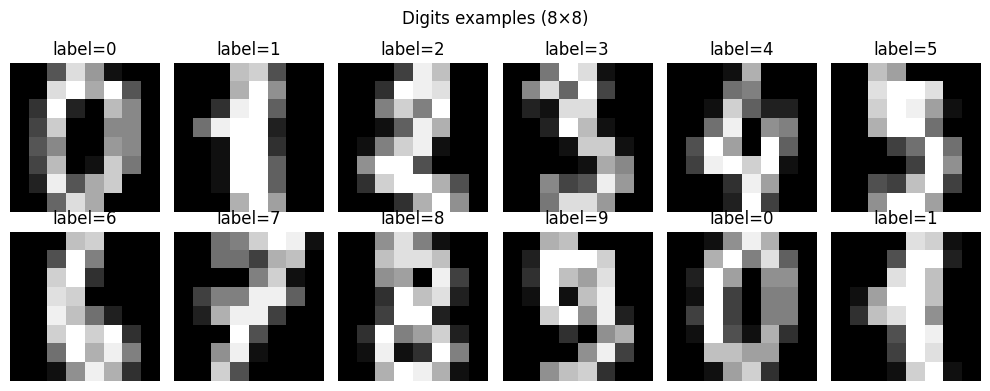

In [3]:
# Посмотрим на несколько примеров изображений
fig, axes = plt.subplots(2, 6, figsize=(10, 4))
for ax, idx in zip(axes.ravel(), range(12)):
    ax.imshow(digits.images[idx], cmap="gray")
    ax.set_title(f"label={y_true[idx]}")
    ax.axis("off")
plt.suptitle("Digits examples (8×8)")
plt.tight_layout()
plt.show()


### 1.1 Масштабирование

Метрики и алгоритмы, основанные на расстояниях (а KMeans – именно такой), очень чувствительны к масштабу признаков.
Для Digits масштаб не “катастрофически” разный, но **правило хорошей практики** – всегда начинать со `StandardScaler`.


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled: mean ~", X_scaled.mean(axis=0).round(3)[:5], "...")
print("Scaled: std  ~", X_scaled.std(axis=0).round(3)[:5], "...")


Scaled: mean ~ [ 0. -0. -0. -0.  0.] ...
Scaled: std  ~ [0. 1. 1. 1. 1.] ...


## 2. Внутренние метрики качества кластеров

Мы хотим оценить “насколько хорошо” кластеризация разделяет данные, **не имея истинных меток**.

Три базовые внутренние метрики:
- **Silhouette** (выше – лучше): насколько точки ближе к своему кластеру, чем к соседнему.
- **Davies-Bouldin** (ниже – лучше): баланс компактности кластеров и их разделимости.
- **Calinski-Harabasz** (выше – лучше): соотношение межкластерной дисперсии к внутрикластерной.

Важно:
- эти метрики помогают **сравнивать варианты**, но не дают “абсолютной истины”;
- оптимизируя одну метрику, вы получите то, что она “поощряет”.

In [5]:
def kmeans_labels(X, k, random_state=RANDOM_STATE):
    # n_init='auto' – современный режим в sklearn; на старых версиях может потребоваться n_init=10
    try:
        model = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    except TypeError:
        model = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    return model.fit_predict(X)

def compute_metrics_over_k(X, k_values):
    sil = []
    db = []
    ch = []
    inertia = []

    for k in k_values:
        labels = kmeans_labels(X, k)

        sil.append(silhouette_score(X, labels))
        db.append(davies_bouldin_score(X, labels))
        ch.append(calinski_harabasz_score(X, labels))

        # Для "локтя" (elbow) – полезно иметь inertia
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto").fit(X)
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10).fit(X)
        inertia.append(model.inertia_)

    return np.array(sil), np.array(db), np.array(ch), np.array(inertia)

k_values = list(range(2, 21))
sil, db, ch, inertia = compute_metrics_over_k(X_scaled, k_values)


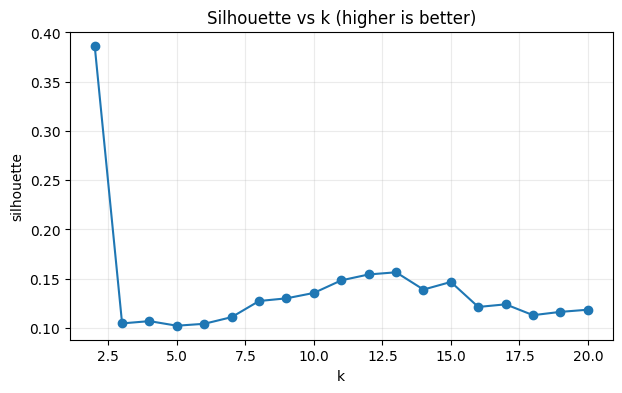

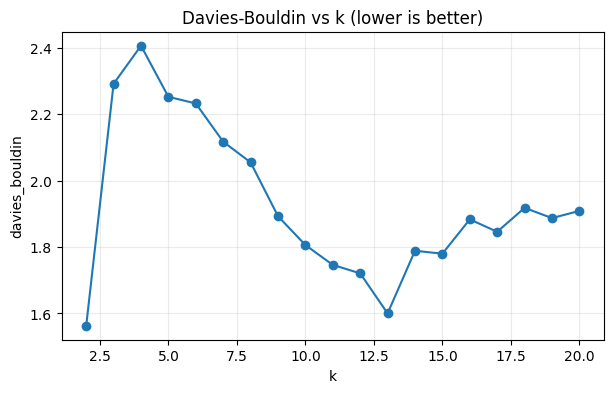

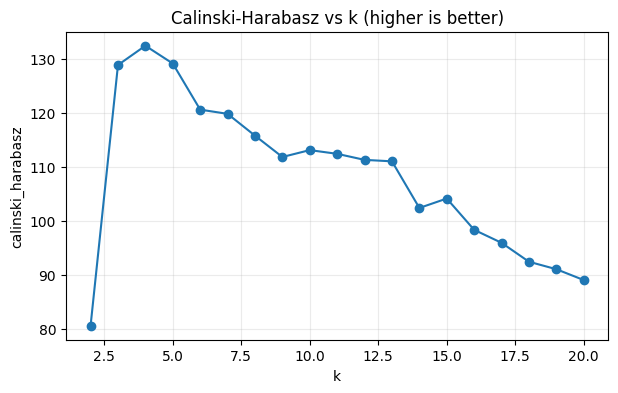

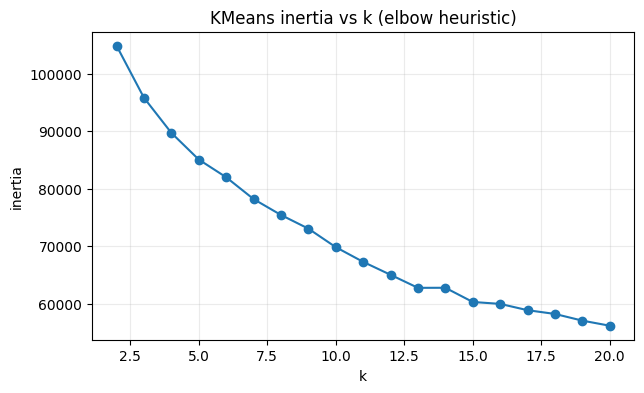

In [6]:
# Визуализируем внутренние метрики + "локоть"
plt.figure(figsize=(7, 4))
plt.plot(k_values, sil, marker="o")
plt.title("Silhouette vs k (higher is better)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, db, marker="o")
plt.title("Davies-Bouldin vs k (lower is better)")
plt.xlabel("k")
plt.ylabel("davies_bouldin")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, ch, marker="o")
plt.title("Calinski-Harabasz vs k (higher is better)")
plt.xlabel("k")
plt.ylabel("calinski_harabasz")
plt.grid(True, alpha=0.25)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(k_values, inertia, marker="o")
plt.title("KMeans inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.show()


### 2.1 Как выбрать `k` на практике?

На Digits “истинно” 10 классов, но мы **делаем вид, что этого не знаем**.
Внутренние метрики часто дают максимум не на `k=10` – и это нормально.

Практическая логика:
- выбрать 2-3 “кандидатных” `k` по метрикам;
- посмотреть устойчивость (разные `random_state`, `n_init`);
- посмотреть интерпретируемость кластеров (что внутри кластеров?);
- и только после этого фиксировать решение.

Ниже возьмём `k=10` как разумный ориентир для демонстрации визуализации.


In [7]:
k = 10
labels_k10 = kmeans_labels(X_scaled, k=k)
print("k =", k)
print("silhouette:", round(silhouette_score(X_scaled, labels_k10), 3))
print("davies_bouldin:", round(davies_bouldin_score(X_scaled, labels_k10), 3))
print("calinski_harabasz:", round(calinski_harabasz_score(X_scaled, labels_k10), 1))


k = 10
silhouette: 0.136
davies_bouldin: 1.806
calinski_harabasz: 113.1


## 3. PCA: сжатие размерности и 2D-визуализация

PCA ищет направления максимальной дисперсии. Это полезно, чтобы:
- ускорять дальнейшие методы (включая t-SNE);
- понимать, “сколько измерений реально нужно”;
- строить 2D/3D-карты для анализа структуры.

Важно: PCA – линейный метод. Если структура нелинейная, PCA может не показать “красивые” группы.

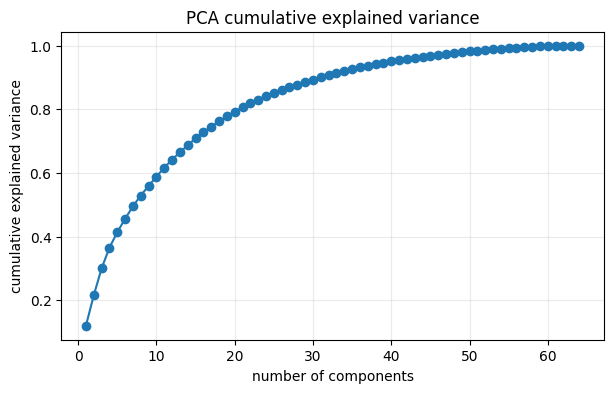

Variance explained by first 2 components: 0.216
Variance explained by first 10 components: 0.589


In [8]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

explained = pca_full.explained_variance_ratio_
cum = np.cumsum(explained)

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(cum) + 1), cum, marker="o")
plt.title("PCA cumulative explained variance")
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.grid(True, alpha=0.25)
plt.show()

print("Variance explained by first 2 components:", round(cum[1], 3))
print("Variance explained by first 10 components:", round(cum[9], 3))


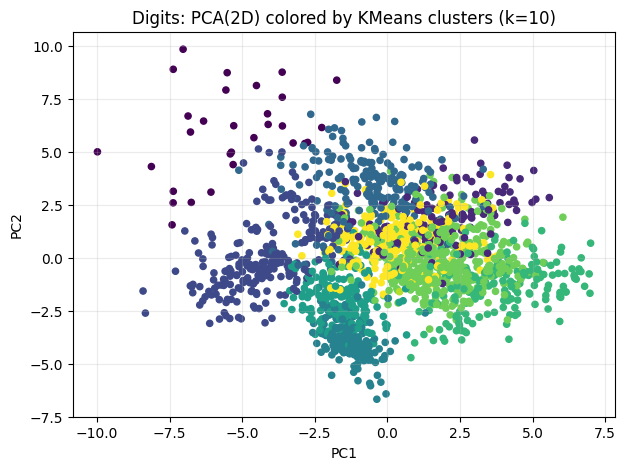

In [9]:
# PCA в 2D – просто чтобы посмотреть
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=labels_k10, s=20)
plt.title("Digits: PCA(2D) colored by KMeans clusters (k=10)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.25)
plt.show()


## 4. t-SNE: нелинейная “карта” локальной структуры

t-SNE старается сохранить **локальные соседства** в 2D. Это отлично для визуального анализа, но важно помнить:
- t-SNE **не оптимизирует** silhouette/DB/CH и не “доказывает” хорошую кластеризацию;
- глобальные расстояния на карте t-SNE часто нельзя интерпретировать буквально;
- результат зависит от параметров (perplexity, learning_rate, init, random_state).

Хорошая практика:
1) сначала уменьшить размерность через PCA до 30–50 компонент (ускорение и шумоподавление),
2) потом запускать t-SNE.

In [10]:
# PCA до 30 компонент перед t-SNE (ускоряет и часто улучшает стабильность)
pca30 = PCA(n_components=30, random_state=RANDOM_STATE)
X_pca30 = pca30.fit_transform(X_scaled)
print("X_pca30.shape:", X_pca30.shape)


X_pca30.shape: (1797, 30)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


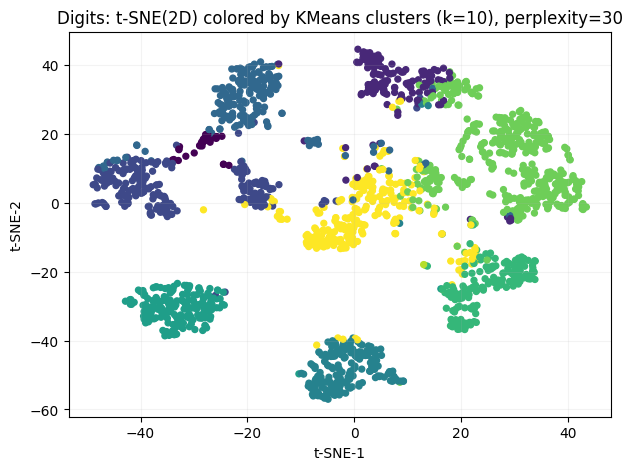

In [11]:
def tsne_embed(X, perplexity=30, learning_rate="auto", random_state=RANDOM_STATE):
    # Параметры подобраны так, чтобы запуск был адекватным по времени на обычной машине.
    # Если медленно – уменьшайте n_iter или берите подвыборку.
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        init="pca",
        random_state=random_state,
        n_iter=1000,
    )
    return tsne.fit_transform(X)

# Один "базовый" запуск
X_tsne = tsne_embed(X_pca30, perplexity=30)

plt.figure(figsize=(7, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_k10, s=18)
plt.title("Digits: t-SNE(2D) colored by KMeans clusters (k=10), perplexity=30")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True, alpha=0.15)
plt.show()


### 4.1 Как влияет perplexity (быстрый сравнительный эксперимент)

Perplexity примерно отвечает за “размер локального окружения”.
Проверим несколько значений. Не ожидайте, что одно значение будет “правильным” всегда.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


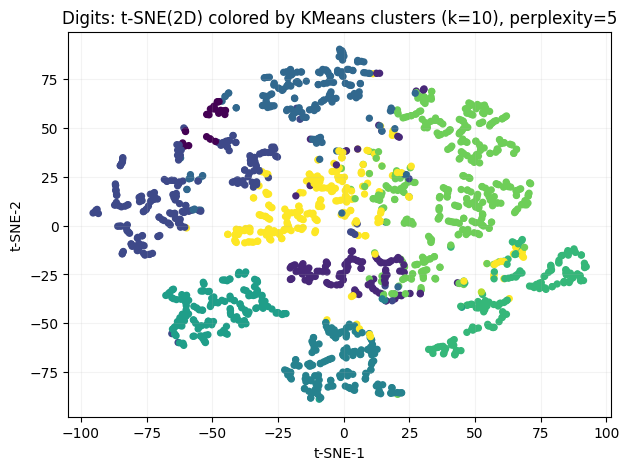

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


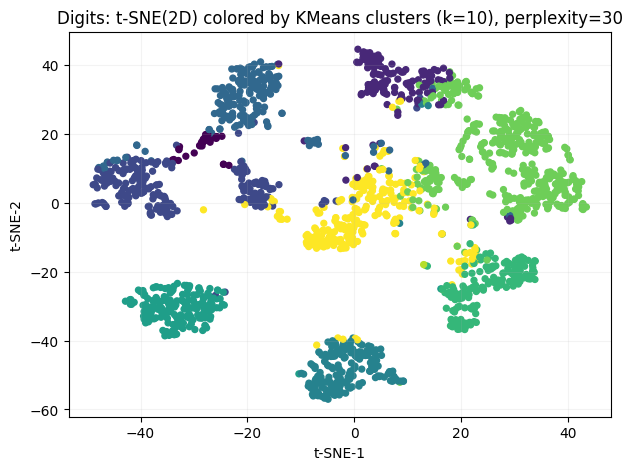

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


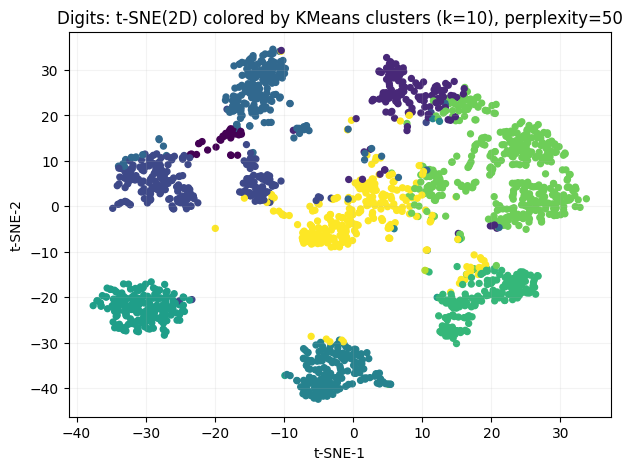

In [12]:
perplexities = [5, 30, 50]

for p in perplexities:
    emb = tsne_embed(X_pca30, perplexity=p)
    plt.figure(figsize=(7, 5))
    plt.scatter(emb[:, 0], emb[:, 1], c=labels_k10, s=18)
    plt.title(f"Digits: t-SNE(2D) colored by KMeans clusters (k=10), perplexity={p}")
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    plt.grid(True, alpha=0.15)
    plt.show()


## 5. (Учебный бонус) Внешние метрики – только когда есть эталонные метки

В реальных задачах кластеризации истинных меток обычно нет.
Но на Digits они есть, поэтому можно оценить “насколько кластеры похожи на классы” через:
- **ARI** (Adjusted Rand Index): 1 – идеально, 0 – примерно случайно;
- **NMI** (Normalized Mutual Information): 1 – идеально.

Это необязательный и часто невозможный шаг в реальном unsupervised – здесь он только для ориентира.

ARI  (true labels vs clusters): 0.531
NMI  (true labels vs clusters): 0.672


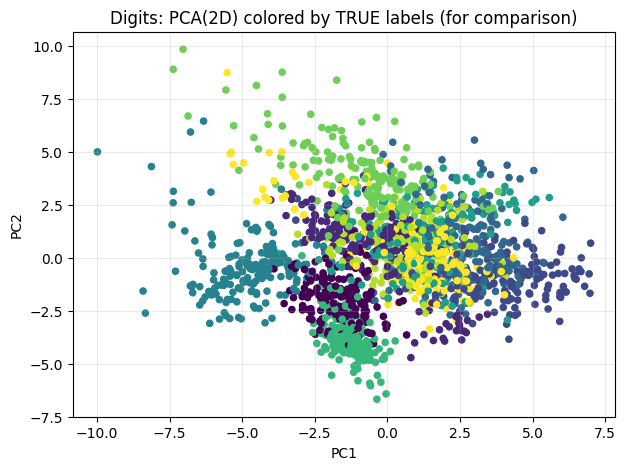

In [13]:
ari = adjusted_rand_score(y_true, labels_k10)
nmi = normalized_mutual_info_score(y_true, labels_k10)

print("ARI  (true labels vs clusters):", round(ari, 3))
print("NMI  (true labels vs clusters):", round(nmi, 3))

# Визуализация PCA(2D) с истинными классами для сравнения
plt.figure(figsize=(7, 5))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y_true, s=20)
plt.title("Digits: PCA(2D) colored by TRUE labels (for comparison)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.25)
plt.show()


## 6. Мини-упражнение на табличных данных: Wine (коротко)

Чтобы увидеть, что всё это работает не только на изображениях, возьмём `load_wine()`:
13 признаков, 3 класса (классы – только для учебного контроля).

Wine X.shape: (178, 13)
Wine classes: [0 1 2]
Wine k=3 silhouette: 0.285
Wine ARI (bonus): 0.897


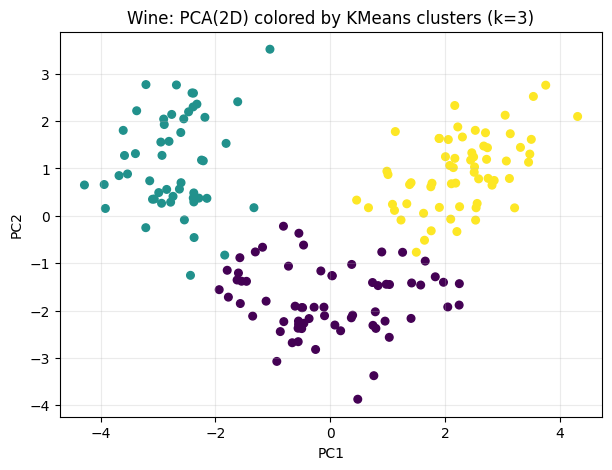

In [14]:
wine = load_wine()
Xw = wine.data
yw = wine.target

print("Wine X.shape:", Xw.shape)
print("Wine classes:", np.unique(yw))

Xw_scaled = StandardScaler().fit_transform(Xw)

k = 3
labels_w = kmeans_labels(Xw_scaled, k=k)

print("Wine k=3 silhouette:", round(silhouette_score(Xw_scaled, labels_w), 3))
print("Wine ARI (bonus):", round(adjusted_rand_score(yw, labels_w), 3))

# PCA(2D) для Wine
Xw_pca2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xw_scaled)
plt.figure(figsize=(7, 5))
plt.scatter(Xw_pca2[:, 0], Xw_pca2[:, 1], c=labels_w, s=30)
plt.title("Wine: PCA(2D) colored by KMeans clusters (k=3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.25)
plt.show()


## Короткие выводы
- Внутренние метрики (silhouette/DB/CH) помогают **сравнить варианты**, но не дают “абсолютной истины”.
- PCA полезна как инструмент **сжатия** и **понимания структуры**, особенно перед t-SNE.
- t-SNE – мощная визуализация локальной структуры, но её легко **переинтерпретировать**.
- Если есть истинные метки (редко в реальности) – можно дополнительно проверить ARI/NMI как учебный контроль.